In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os import path
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
data = pd.read_excel(path.join('data', 'yahoo_data.xlsx'))
# sort by date
data['Date'] = pd.to_datetime(data['Date'])
data=data.sort_values(by="Date",ascending=True)
data.set_index("Date",inplace=True)
data.head()


,Open,High,Low,Close*,Adj Close**,Volume
Date,,,,,,
2018-05-01,24117.29,24117.29,23808.19,24099.05,24099.05,380070000
2018-05-02,24097.63,24185.52,23886.30,23924.98,23924.98,385350000
2018-05-03,23836.23,23996.15,23531.31,23930.15,23930.15,389240000
2018-05-04,23865.22,24333.35,23778.87,24262.51,24262.51,329480000
2018-05-07,24317.66,24479.45,24263.42,24357.32,24357.32,307670000


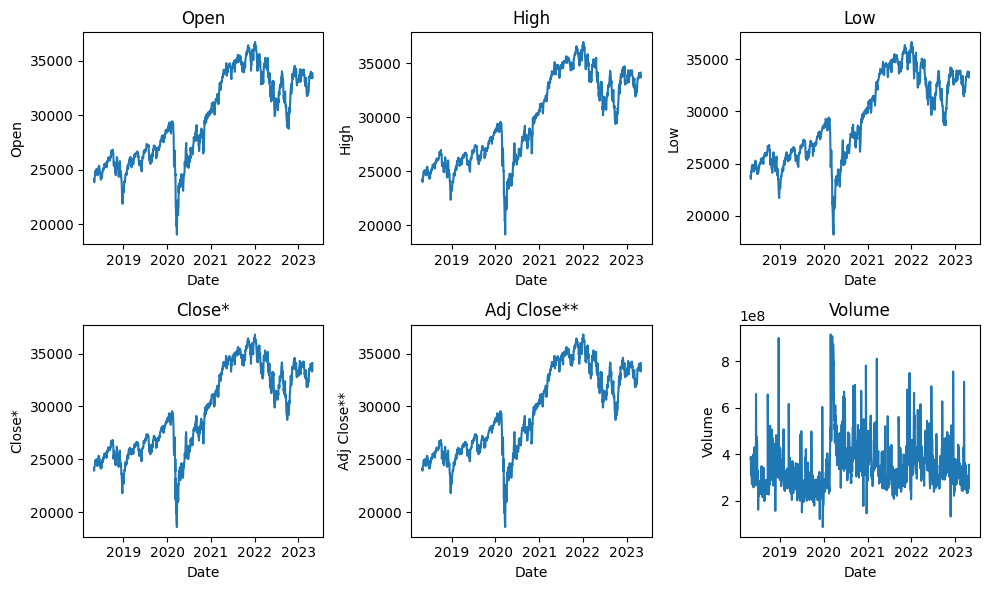

In [3]:
# plot the first 6 columns
# rearrange them at 2x2 grid
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    sns.lineplot(data=data.iloc[:, i])
    plt.title(data.columns[i])
plt.tight_layout()
plt.show()

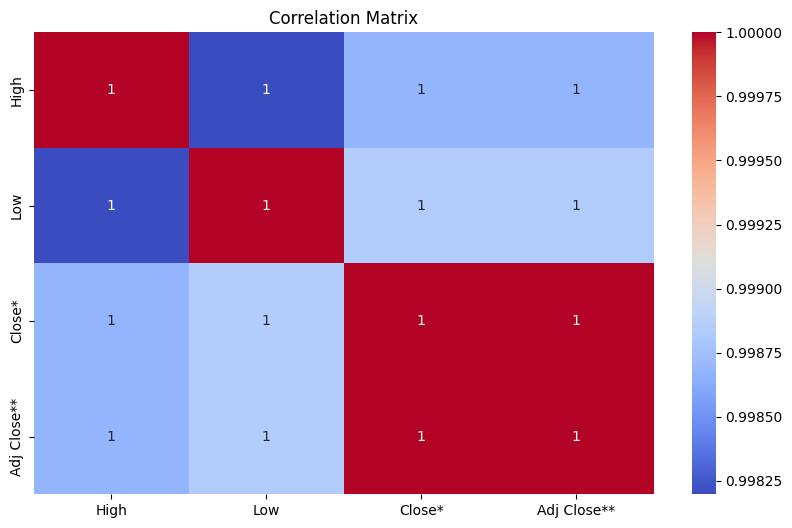

In [4]:
# it seems like first 4 columns are strongly correlated
# let's plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(data.iloc[:, 1:5].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Filtering features

We can see that all of teh features, except for the volume are, are strongly correlated with each other. This means that we can use only one of them to predict the target.

<Axes: xlabel='Date', ylabel='Close*'>

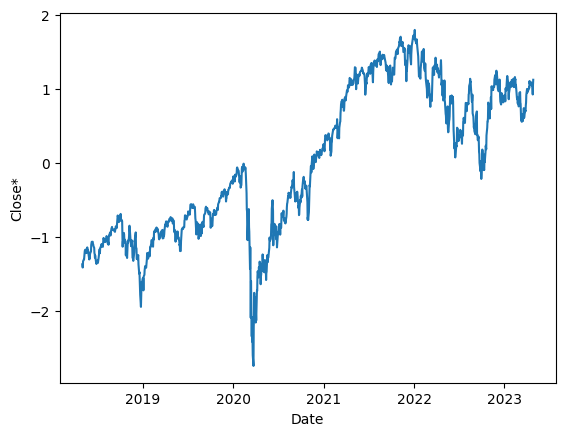

In [5]:
from sklearn.preprocessing import StandardScaler

data['Close*'] = StandardScaler().fit_transform(data[['Close*']])
sns.lineplot(data['Close*'])

## Creating a dataset for prediction

In [6]:
from sklearn.model_selection import train_test_split

def create_data(dataset, window_size=50):
    """
    Create a dataset with a window size of 10

    Parameters:
    -----------
    dataset: pd.DataFrame
        The dataset to be used

    Returns:
    --------
    X: np.array
        The input data
    y: np.array
        The output data
    """

    X, y = [], []
    for i in range(window_size, len(dataset)):
        X.append(dataset[i-window_size:i])
        y.append(dataset[i])
    return np.array(X), np.array(y)


# create the dataset
X, y = create_data(data['Close*'])

train_inds = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:train_inds], X[train_inds:], y[:train_inds], y[train_inds:]

## Making a Machine Learning model

To make a model, we will use LSTM. LSTM is a type of RNN that is capable of learning long-term dependencies. It is widely used in time series forecasting.

In [7]:
model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(50, 1)),
        tf.keras.layers.LSTM(64, return_sequences=False),
        tf.keras.layers.Dense(1)
    ])

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
31/31 [==============================] - 4s 60ms/step - loss: 0.1296 - val_loss: 0.0469
Epoch 2/50
31/31 [==============================] - 1s 41ms/step - loss: 0.0318 - val_loss: 0.0421
Epoch 3/50
31/31 [==============================] - 1s 41ms/step - loss: 0.0259 - val_loss: 0.0378
Epoch 4/50
31/31 [==============================] - 1s 41ms/step - loss: 0.0234 - val_loss: 0.0346
Epoch 5/50
31/31 [==============================] - 1s 44ms/step - loss: 0.0229 - val_loss: 0.0317
Epoch 6/50
31/31 [==============================] - 1s 42ms/step - loss: 0.0203 - val_loss: 0.0298
Epoch 7/50
31/31 [==============================] - 1s 42ms/step - loss: 0.0202 - val_loss: 0.0303
Epoch 8/50
31/31 [==============================] - 1s 43ms/step - loss: 0.0190 - val_loss: 0.0275
Epoch 9/50
31/31 [==============================] - 1s 42ms/step - loss: 0.0181 - val_loss: 0.0285
Epoch 10/50
31/31 [==============================] - 1s 42ms/step - loss: 0.0176 - val_loss: 0.0250
Epoch 11/

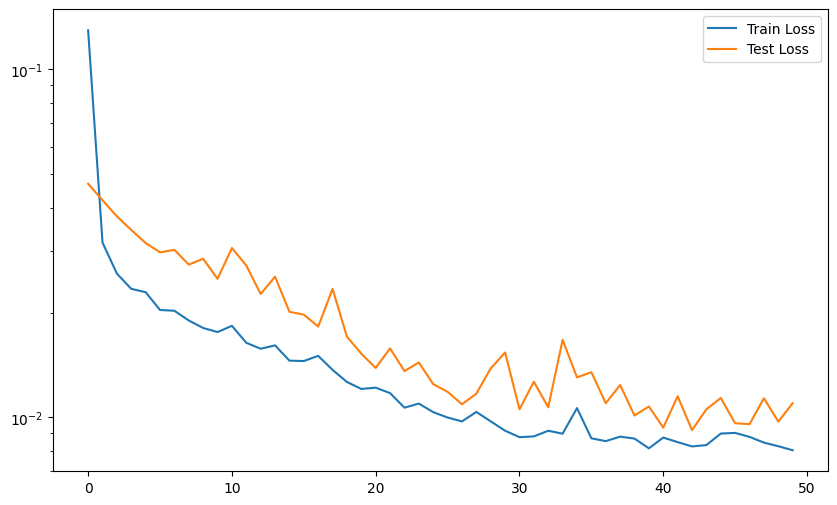

In [8]:
# plot train and test lost
plt.figure(figsize=(10, 6))
plt.plot(model.history.history['loss'], label='Train Loss')
plt.plot(model.history.history['val_loss'], label='Test Loss')
plt.legend()
plt.yscale('log')
plt.show()

8/8 [==============================] - 0s 14ms/step


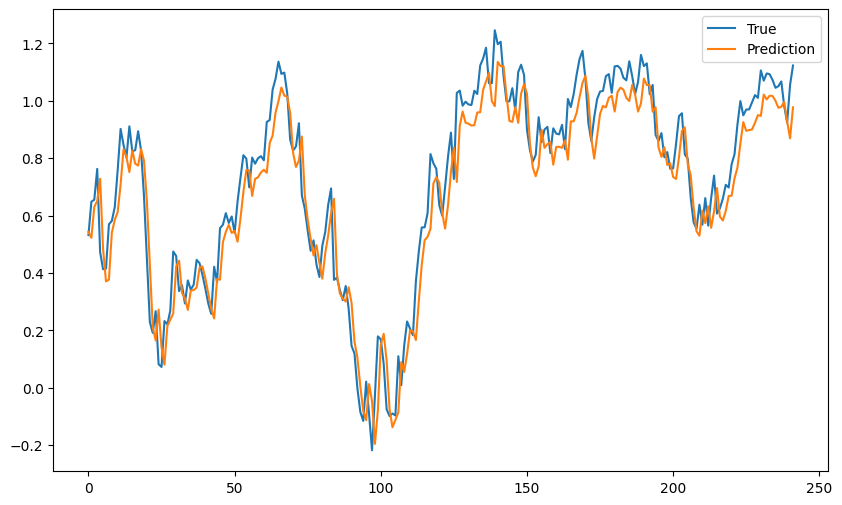

In [11]:
# plot the prediction
y_pred = model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Prediction')
plt.legend()
